In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

# Load data

In [44]:
train_df = pd.read_csv("../data/final/train.csv", parse_dates=True, index_col=0)
val_df = pd.read_csv("../data/final/val.csv", parse_dates=True, index_col=0)
test_df = pd.read_csv("../data/final/test.csv", parse_dates=True, index_col=0)

In [45]:
train_df.head()

,hs,tp,mwd
Datum Tid (UTC),,,
2007-07-01 00:00:00,0.60,4.00,236.25
2007-07-01 01:00:00,0.58,3.92,241.88
2007-07-01 02:00:00,0.59,3.88,247.50
2007-07-01 03:00:00,0.67,3.85,241.88
2007-07-01 04:00:00,0.70,4.12,247.50


# Feature engineering

In [46]:
def angle_to_vector(df):
    # Convert to radians.
    wd_rad = df.pop('mwd')*np.pi / 180

    # Calculate the wind x and y components.
    df['wx'] = np.cos(wd_rad)
    df['wy'] = np.sin(wd_rad)

In [47]:
angle_to_vector(train_df)
angle_to_vector(val_df)
angle_to_vector(test_df)

In [48]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [49]:
def create_multi_target(df, lookback=24, horizon=24):
  df = df.copy() # don't mess up orginal

  n_rows = df.shape[0]
  n_features = df.shape[1]
  n_examples = n_rows - lookback - horizon

  X = np.zeros(shape=(n_examples, lookback, n_features))
  y = np.zeros(shape=(n_examples, horizon))
  for j in range(n_examples):
            X[j] = df.iloc[j:j+lookback]
            y[j] = df['hs'].iloc[j+lookback:j+horizon+lookback]
  return X,y

X_train, y_train = create_multi_target(train_df, horizon=6)
X_val, y_val = create_multi_target(val_df, horizon=6)
X_test, y_test = create_multi_target(test_df, horizon=6)

In [63]:
y_train.max()

6.18581309622218

# Dense model

In [82]:
dense_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=6)
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=3,
                                                    mode='min',
                                                  restore_best_weights=True
                                                 )

dense_model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = dense_model.fit(X_train, y_train, epochs=20,
                          batch_size=128,
                      validation_data=(X_val,y_val),
                      callbacks=[early_stopping])

Epoch 1/20
172/172 [==============================] - 3s 17ms/step - loss: 0.3259 - mean_absolute_error: 0.4044 - val_loss: 0.1103 - val_mean_absolute_error: 0.2433
Epoch 2/20
172/172 [==============================] - 3s 18ms/step - loss: 0.1634 - mean_absolute_error: 0.2827 - val_loss: 0.1006 - val_mean_absolute_error: 0.2289
Epoch 3/20
172/172 [==============================] - 3s 20ms/step - loss: 0.1580 - mean_absolute_error: 0.2739 - val_loss: 0.0988 - val_mean_absolute_error: 0.2273
Epoch 4/20
172/172 [==============================] - 3s 19ms/step - loss: 0.1421 - mean_absolute_error: 0.2611 - val_loss: 0.0995 - val_mean_absolute_error: 0.2320
Epoch 5/20
172/172 [==============================] - 3s 19ms/step - loss: 0.1431 - mean_absolute_error: 0.2585 - val_loss: 0.0951 - val_mean_absolute_error: 0.2188
Epoch 6/20
172/172 [==============================] - 3s 19ms/step - loss: 0.1290 - mean_absolute_error: 0.2451 - val_loss: 0.0940 - val_mean_absolute_error: 0.2060
Epoch 7/20

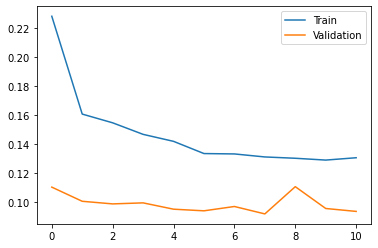

In [83]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()

In [84]:
dense_model.evaluate(X_test, y_test)

817/817 [==============================] - 2s 3ms/step - loss: 0.1077 - mean_absolute_error: 0.2174


[0.10766378045082092, 0.21739806234836578]

In [107]:
def plot_forecast(idx=0):
  plt.scatter(range(-23,1),X_test[idx,:,0], label='X')
  plt.plot(range(1,7),y_test[idx], label='y',linewidth=4)
  plt.plot(range(1,7),dense_model.predict(X_test[[idx]])[0], label='dense')
  plt.legend(loc='upper left')
  plt.ylabel("Normalized wave height")
  plt.xlabel("Relative time (h)")
  plt.ylim([y_train.min(),y_train.max()])

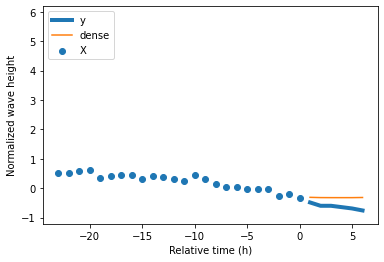

In [108]:
plot_forecast(5017)

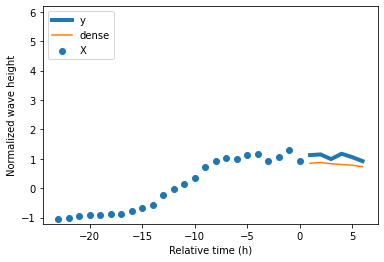

In [109]:
plot_forecast(26115)

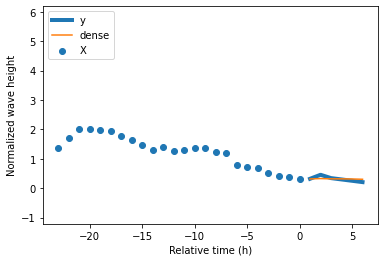

In [110]:
plot_forecast(2611)

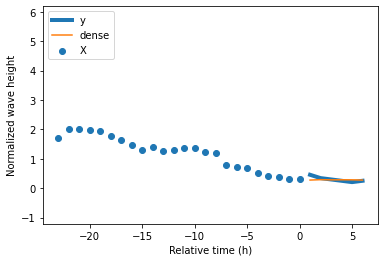

In [111]:
plot_forecast(2612)

# MC Dropout

In [121]:
nsamples = 100
nexamples = len(y_test)
horizon = 6
y_pred_all = np.zeros(shape=(nsamples,nexamples,horizon))

for i in range(nsamples):
    y_pred_all[i] =dense_model(X_test, training=True)

(-1.2089528601145143, 6.18581309622218)

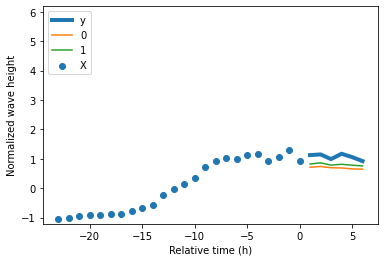

In [124]:
idx = 26115

plt.scatter(range(-23,1),X_test[idx,:,0], label='X')
plt.plot(range(1,7),y_test[idx], label='y',linewidth=4)
plt.plot(range(1,7),y_pred_all[0,idx,:], label='0')
plt.plot(range(1,7),y_pred_all[1,idx,:], label='1')
plt.legend(loc='upper left')
plt.ylabel("Normalized wave height")
plt.xlabel("Relative time (h)")
plt.ylim([y_train.min(),y_train.max()])

In [127]:
y_pred_all_min = y_pred_all.min(axis=0)
y_pred_all_max = y_pred_all.max(axis=0)
y_pred_all_mean = y_pred_all.mean(axis=0)

(-1.2089528601145143, 6.18581309622218)

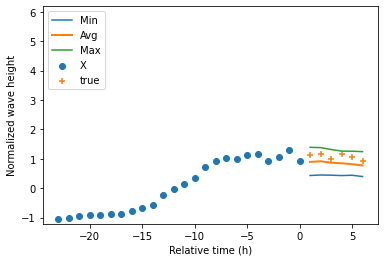

In [131]:
idx = 26115

plt.scatter(range(-23,1),X_test[idx,:,0], label='X')
plt.scatter(range(1,7),y_test[idx], label='true',marker='+')
plt.plot(range(1,7),y_pred_all_min[idx,:], label='Min')
plt.plot(range(1,7),y_pred_all_mean[idx,:], label='Avg', linewidth=2)
plt.plot(range(1,7),y_pred_all_max[idx,:], label='Max')
plt.legend(loc='upper left')
plt.ylabel("Normalized wave height")
plt.xlabel("Relative time (h)")
plt.ylim([y_train.min(),y_train.max()])

(-1.2089528601145143, 6.18581309622218)

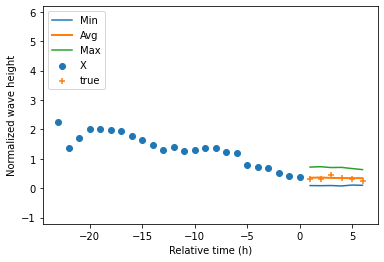

In [133]:
idx = 2610

plt.scatter(range(-23,1),X_test[idx,:,0], label='X')
plt.scatter(range(1,7),y_test[idx], label='true',marker='+')
plt.plot(range(1,7),y_pred_all_min[idx,:], label='Min')
plt.plot(range(1,7),y_pred_all_mean[idx,:], label='Avg', linewidth=2)
plt.plot(range(1,7),y_pred_all_max[idx,:], label='Max')
plt.legend(loc='upper left')
plt.ylabel("Normalized wave height")
plt.xlabel("Relative time (h)")
plt.ylim([y_train.min(),y_train.max()])

(-1.2089528601145143, 6.18581309622218)

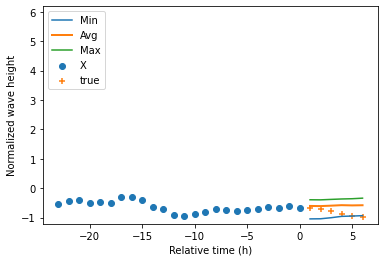

In [137]:
idx = 20000

plt.scatter(range(-23,1),X_test[idx,:,0], label='X')
plt.scatter(range(1,7),y_test[idx], label='true',marker='+')
plt.plot(range(1,7),y_pred_all_min[idx,:], label='Min')
plt.plot(range(1,7),y_pred_all_mean[idx,:], label='Avg', linewidth=2)
plt.plot(range(1,7),y_pred_all_max[idx,:], label='Max')
plt.legend(loc='upper left')
plt.ylabel("Normalized wave height")
plt.xlabel("Relative time (h)")
plt.ylim([y_train.min(),y_train.max()])

(array([ 1.,  3.,  2.,  8., 13., 20., 24., 15.,  8.,  6.]),
 array([-0.93198591, -0.87250944, -0.81303297, -0.75355649, -0.69408002,
        -0.63460355, -0.57512707, -0.5156506 , -0.45617412, -0.39669765,
        -0.33722118]),
 <BarContainer object of 10 artists>)

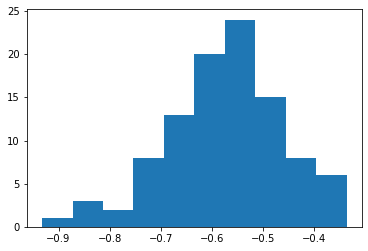

In [142]:
plt.hist(y_pred_all[:,idx,5])

(array([54852., 37602., 18558., 11490.,  5412.,  2364.,   798.,   342.,
           90.,    72.]),
 array([-1.20895286, -0.46947626,  0.27000033,  1.00947693,  1.74895352,
         2.48843012,  3.22790671,  3.96738331,  4.7068599 ,  5.4463365 ,
         6.1858131 ]),
 <BarContainer object of 10 artists>)

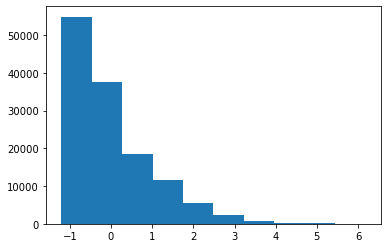

In [146]:
plt.hist(y_train.flatten())